<a href="https://githubtocolab.com/AnaMontanezB/IA_UdeA/blob/main/03_Modelos_supervisados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# **Métodos Supervisados**
#integrantes
Ana María Montañez Becerra   c.c 1152224184

Joanny Torres Cardona        c.c 1152218692

Anteriormente se habian nombrado datos de interés a spo2, nremhr, rmssd, pero desde la exploración de los datos se observo que no existe una correlación fuerte entre estos y muchos de los datos, es por esto que se ha cambiado los parámetro de interés a bmp y rmssd, junto con parametros obtenidos por medio de encuentas

## 1. Instalación de Kaggle e importación de librerias.

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anamariamontanez99","key":"c6906345c84b7c9375444e40db2c3d8f"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d skywescar/lifesnaps-fitbit-dataset

100% 538M/540M [00:28<00:00, 15.0MB/s]
100% 540M/540M [00:28<00:00, 20.1MB/s]


In [ ]:
!unzip '/content/lifesnaps-fitbit-dataset.zip'

Archive:  /content/lifesnaps-fitbit-dataset.zip
  inflating: rais_anonymized/csv_rais_anonymized/daily_fitbit_sema_df_unprocessed.csv  
  inflating: rais_anonymized/csv_rais_anonymized/hourly_fitbit_sema_df_unprocessed.csv  
  inflating: rais_anonymized/mongo_rais_anonymized/fitbit.bson  
  inflating: rais_anonymized/mongo_rais_anonymized/fitbit.metadata.json  
  inflating: rais_anonymized/mongo_rais_anonymized/sema.bson  
  inflating: rais_anonymized/mongo_rais_anonymized/sema.metadata.json  
  inflating: rais_anonymized/mongo_rais_anonymized/surveys.bson  
  inflating: rais_anonymized/mongo_rais_anonymized/surveys.metadata.json  
  inflating: rais_anonymized/scored_surveys/breq.csv  
  inflating: rais_anonymized/scored_surveys/panas.csv  
  inflating: rais_anonymized/scored_surveys/personality.csv  
  inflating: rais_anonymized/scored_surveys/stai.csv  
  inflating: rais_anonymized/scored_surveys/ttm.csv  


In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


In [ ]:
# importación de librerias útiles
import pandas as pd #importación de pandas para mostrar los datos en un dataframe
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from local.lib import calhousing as ch
from progressbar import progressbar as pbar
from local.lib import mlutils
from IPython import display
from sklearn import linear_model
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from matplotlib import cm
from matplotlib import gridspec
from sklearn import metrics

#Librerías de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import learning_curve

%matplotlib inline
d= pd.read_csv (r'/content/rais_anonymized/csv_rais_anonymized/daily_fitbit_sema_df_unprocessed.csv')
newData=d.groupby('id').mean()

##2. Limpieza de dataset

In [ ]:
newData = newData.drop(['scl_avg', 'spo2'], axis=1)#Se eliminan columnas que tienen más del 50% de datos faltantes

In [ ]:
newData.fillna(newData.mean(),inplace=True)    #se reemplazan datos faltantes por la media


Según la literatura los rangos normales de un adulto para latidos por minutos (bpm) está en el rango de 60-100 y para rmssd es entre 19ms-48ms, debido a que todos los datos de bpm del dataset están entre rango, para efectos de clasificación se tomara rangos normales de bpm entre 60-80, los datos que estén por encima se tomaran como personas con taquicardia.

In [ ]:
#NOTA: ya no se van a usar estos datos para el entrenamiento
bpmClassifier=[]
rmssdClassifier=[]
for i in range(0,71):
  if newData['bpm'][i]<80:
    bpmClassifier.append(0) #personas sin taquicardia 0
  else:
    bpmClassifier.append(1) #personas con taquicardia 1
  if newData['rmssd'][i]<48:
    rmssdClassifier.append(0) #personas en rango normal 0
  else:
    rmssdClassifier.append(1) #persona fuera del rango 1
newData['bpmClassifier']=bpmClassifier
newData['rmssdClassifier']=rmssdClassifier
newData

,Unnamed: 0,nightly_temperature,nremhr,rmssd,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,...,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL,bpmClassifier,rmssdClassifier
id,,,,,,,,,,,,,,,,,,,,,
621e2e8e67b776a24055b564,35.000000,34.315168,56.571484,100.410210,15.270968,76.317460,0.795767,0.732540,0.771429,-1.848630,...,0.119048,0.000000,0.238095,0.000000,0.000000,0.500000,0.000000,0.523810,0,1
621e2eaf67b776a2406b14ac,114.500000,34.252140,68.988272,25.992988,14.767500,74.731707,0.742683,0.777439,0.711789,-2.060836,...,0.083333,0.000000,0.750000,0.000000,0.000000,0.416667,0.000000,0.666667,1,0
621e2ed667b776a24085d8d1,215.500000,33.998974,72.814016,26.519625,17.680000,58.837131,0.591607,0.585031,0.589589,-1.372850,...,0.102041,0.020408,0.755102,0.000000,0.000000,0.163265,0.000000,0.428571,1,0
621e2ef567b776a24099f889,322.500000,31.975482,61.727647,41.241060,14.779468,58.837131,0.591607,0.585031,0.589589,-1.435831,...,0.068987,0.008074,0.710343,0.095529,0.016242,0.140065,0.072657,0.280589,1,0
621e2efa67b776a2409dd1c3,441.000000,34.167044,61.727647,41.241060,14.779468,58.837131,0.591607,0.585031,0.589589,-1.124220,...,0.068987,0.008074,0.710343,0.095529,0.016242,0.140065,0.072657,0.280589,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621e36c267b776a240ba2756,6956.500000,33.345793,61.727647,41.241060,14.779468,61.818182,0.590152,0.657386,0.593939,-0.222112,...,0.157895,0.000000,0.631579,0.000000,0.000000,0.052632,0.052632,0.105263,1,0
621e36dd67b776a240ce9a45,7067.000000,33.437228,61.727647,41.241060,14.779468,23.333333,0.188889,0.225000,0.288889,-1.435831,...,0.000000,0.000000,0.125000,0.000000,0.000000,0.125000,0.291667,0.458333,0,0
621e36f967b776a240e5e7c9,7184.285714,33.988318,60.920045,70.315795,14.715556,68.717391,0.714493,0.681522,0.667391,-2.152995,...,0.071429,0.000000,0.785714,0.000000,0.095238,0.107143,0.357143,0.238095,1,1


_________________________________________________________________

## 3.Preparación de datos para entrenamiento

Procesamiento de atributos

In [ ]:
def preprocess_features(newData):#procesamos los atributos

  selected_features = newData[
    ["stress_score", 
     "sleep_points_percentage",
     "exertion_points_percentage", 
     "responsiveness_points_percentage",
     "daily_temperature_variation", 
     "calories", 
     "filteredDemographicVO2Max",
     "nremhr","rmssd", 
     "bpm"]]
  processed_features = selected_features.copy()

  return  processed_features

def preprocess_targets(newData): #procesamos los datos de salida 
 
  output_targets = pd.DataFrame()
  output_targets["stress_score"] = (newData["stress_score"])
  return output_targets

Separación de datos de entrenamiento y validación

In [ ]:

training_examples = preprocess_features(newData.head(57))
training_targets = preprocess_targets(newData.head(57))

#Se escoge datos para validación
validation_examples = preprocess_features(newData.tail(14))
validation_targets = preprocess_targets(newData.tail(14))

#Se realiza 
print("Training examples summary:")
display.display(training_examples.describe())
display.display(training_examples.shape)
print("Validation examples summary:")
display.display(validation_examples.describe())
display.display(validation_examples.shape)

print("Training targets summary:")
display.display(training_targets.describe())
display.display(training_targets.shape)
print("Validation targets summary:")
display.display(validation_targets.describe())
display.display(validation_targets.shape)

Training examples summary:


,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,calories,filteredDemographicVO2Max,nremhr,rmssd,bpm
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,59.002296,0.596186,0.584629,0.591052,-1.501174,2203.780062,46.052878,61.826278,39.978985,80.495933
std,13.496923,0.145256,0.138027,0.135011,0.711656,471.774966,7.081094,5.449518,12.990083,6.607597
min,12.857143,0.120635,0.138095,0.123810,-3.642628,1211.332256,29.640031,48.402000,19.721788,61.504158
25%,58.837131,0.591607,0.585031,0.589589,-1.935860,1808.433218,41.294298,60.650623,32.166821,77.239824
50%,58.837131,0.591607,0.585031,0.589589,-1.435831,2147.223811,45.307433,61.727647,41.241060,81.070975
75%,63.720000,0.661111,0.620724,0.628472,-0.995066,2559.828117,50.422519,63.523573,41.241060,84.003065
max,81.654545,0.853646,0.876754,0.817647,-0.183216,3335.102969,62.951610,77.548857,100.410210,94.595539


(57, 10)

Validation examples summary:


,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,calories,filteredDemographicVO2Max,nremhr,rmssd,bpm
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,58.164672,0.572961,0.586672,0.583633,-1.169791,2324.099510,44.070470,61.326078,46.379509,81.451180
std,12.586249,0.131164,0.141777,0.106919,0.797082,563.522821,6.687501,5.398833,16.299440,7.016234
min,23.333333,0.188889,0.225000,0.288889,-2.318073,1520.465517,35.466257,48.374200,20.893869,68.933951
25%,57.346075,0.567146,0.569371,0.589589,-1.435831,2028.098196,37.890152,61.121946,39.873512,78.421690
50%,58.837131,0.591607,0.585031,0.589589,-1.371025,2310.730496,43.344992,61.727647,41.241060,80.140417
75%,61.072919,0.591607,0.639298,0.596126,-1.043285,2505.302584,49.534927,63.734314,59.371440,86.071800
max,77.258065,0.718687,0.841532,0.750538,0.913011,3464.951970,53.786904,69.688479,74.383567,92.068997


(14, 10)

Training targets summary:


,stress_score
count,57.000000
mean,59.002296
std,13.496923
min,12.857143
25%,58.837131
50%,58.837131
75%,63.720000
max,81.654545


(57, 1)

Validation targets summary:


,stress_score
count,14.000000
mean,58.164672
std,12.586249
min,23.333333
25%,57.346075
50%,58.837131
75%,61.072919
max,77.258065


(14, 1)

Correlación entre atributos teniendo en cuenta que:
- -1.0 --> correlación negativa perfecta
- 0.0 --> no existe correlación
- 1.0 --> correlación positiva perfecta

Se mira la correlación para elegir los paramétros con correlación y entrenar el algoritmo.

In [ ]:
#mirar la correlacion de datos, para ver si los atributos se encuentran correlacionados con el objetivo 
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["stress_score"]

correlation_dataframe.corr()

,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,daily_temperature_variation,calories,filteredDemographicVO2Max,nremhr,rmssd,bpm,target
stress_score,1.000000,0.969246,0.963191,0.976888,-0.140046,0.052081,0.256028,0.207397,0.069319,-0.216260,1.000000
sleep_points_percentage,0.969246,1.000000,0.879462,0.955471,-0.095913,0.000458,0.237469,0.321847,0.001733,-0.201647,0.969246
exertion_points_percentage,0.963191,0.879462,1.000000,0.900608,-0.124151,0.150967,0.231741,0.126361,0.108765,-0.126688,0.963191
responsiveness_points_percentage,0.976888,0.955471,0.900608,1.000000,-0.194279,-0.032742,0.281861,0.174159,0.079208,-0.331077,0.976888
daily_temperature_variation,-0.140046,-0.095913,-0.124151,-0.194279,1.000000,0.321890,0.118472,0.124146,-0.028132,-0.045025,-0.140046
calories,0.052081,0.000458,0.150967,-0.032742,0.321890,1.000000,0.245221,-0.320878,0.315947,-0.224232,0.052081
filteredDemographicVO2Max,0.256028,0.237469,0.231741,0.281861,0.118472,0.245221,1.000000,-0.534490,0.565013,-0.412255,0.256028
nremhr,0.207397,0.321847,0.126361,0.174159,0.124146,-0.320878,-0.534490,1.000000,-0.440241,0.649189,0.207397
rmssd,0.069319,0.001733,0.108765,0.079208,-0.028132,0.315947,0.565013,-0.440241,1.000000,-0.376737,0.069319
bpm,-0.216260,-0.201647,-0.126688,-0.331077,-0.045025,-0.224232,-0.412255,0.649189,-0.376737,1.000000,-0.216260


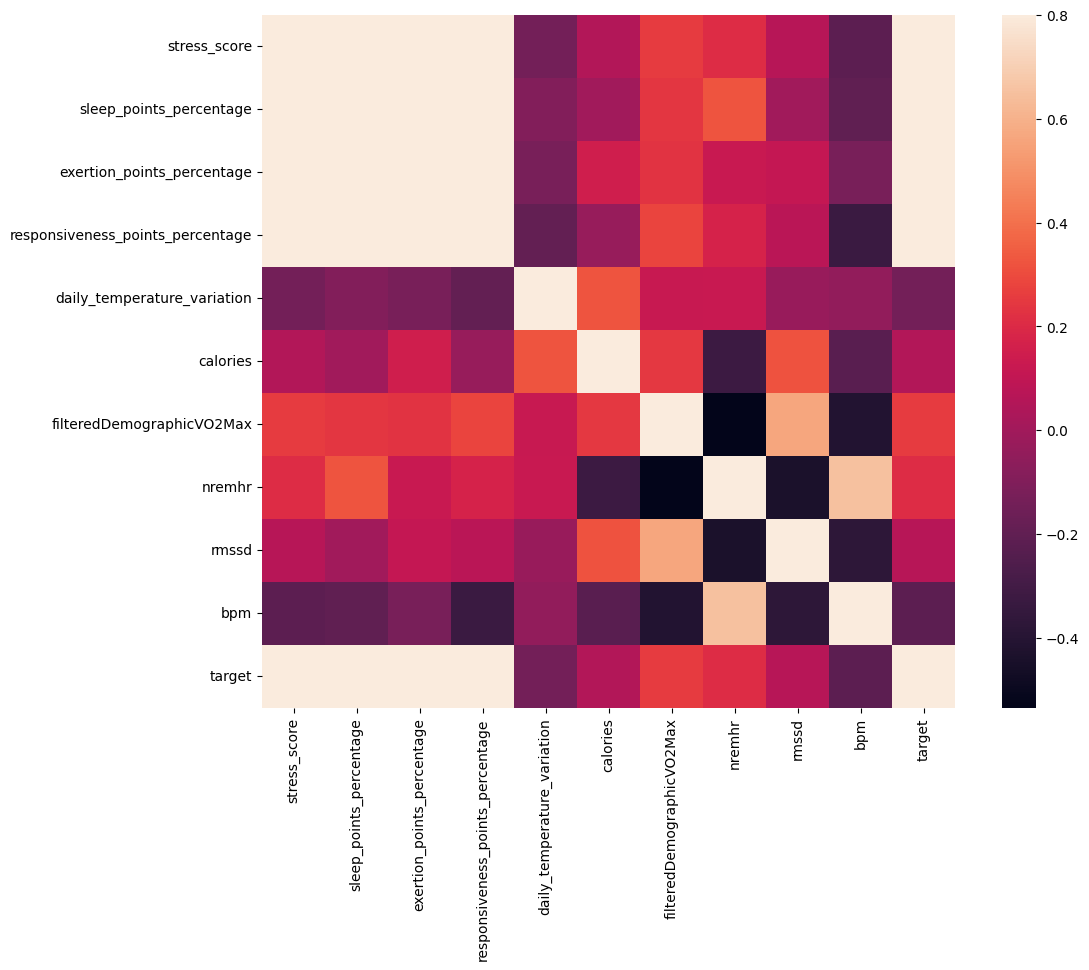

In [ ]:
corrmat = correlation_dataframe.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

<Figure size 10000x10000 with 0 Axes>

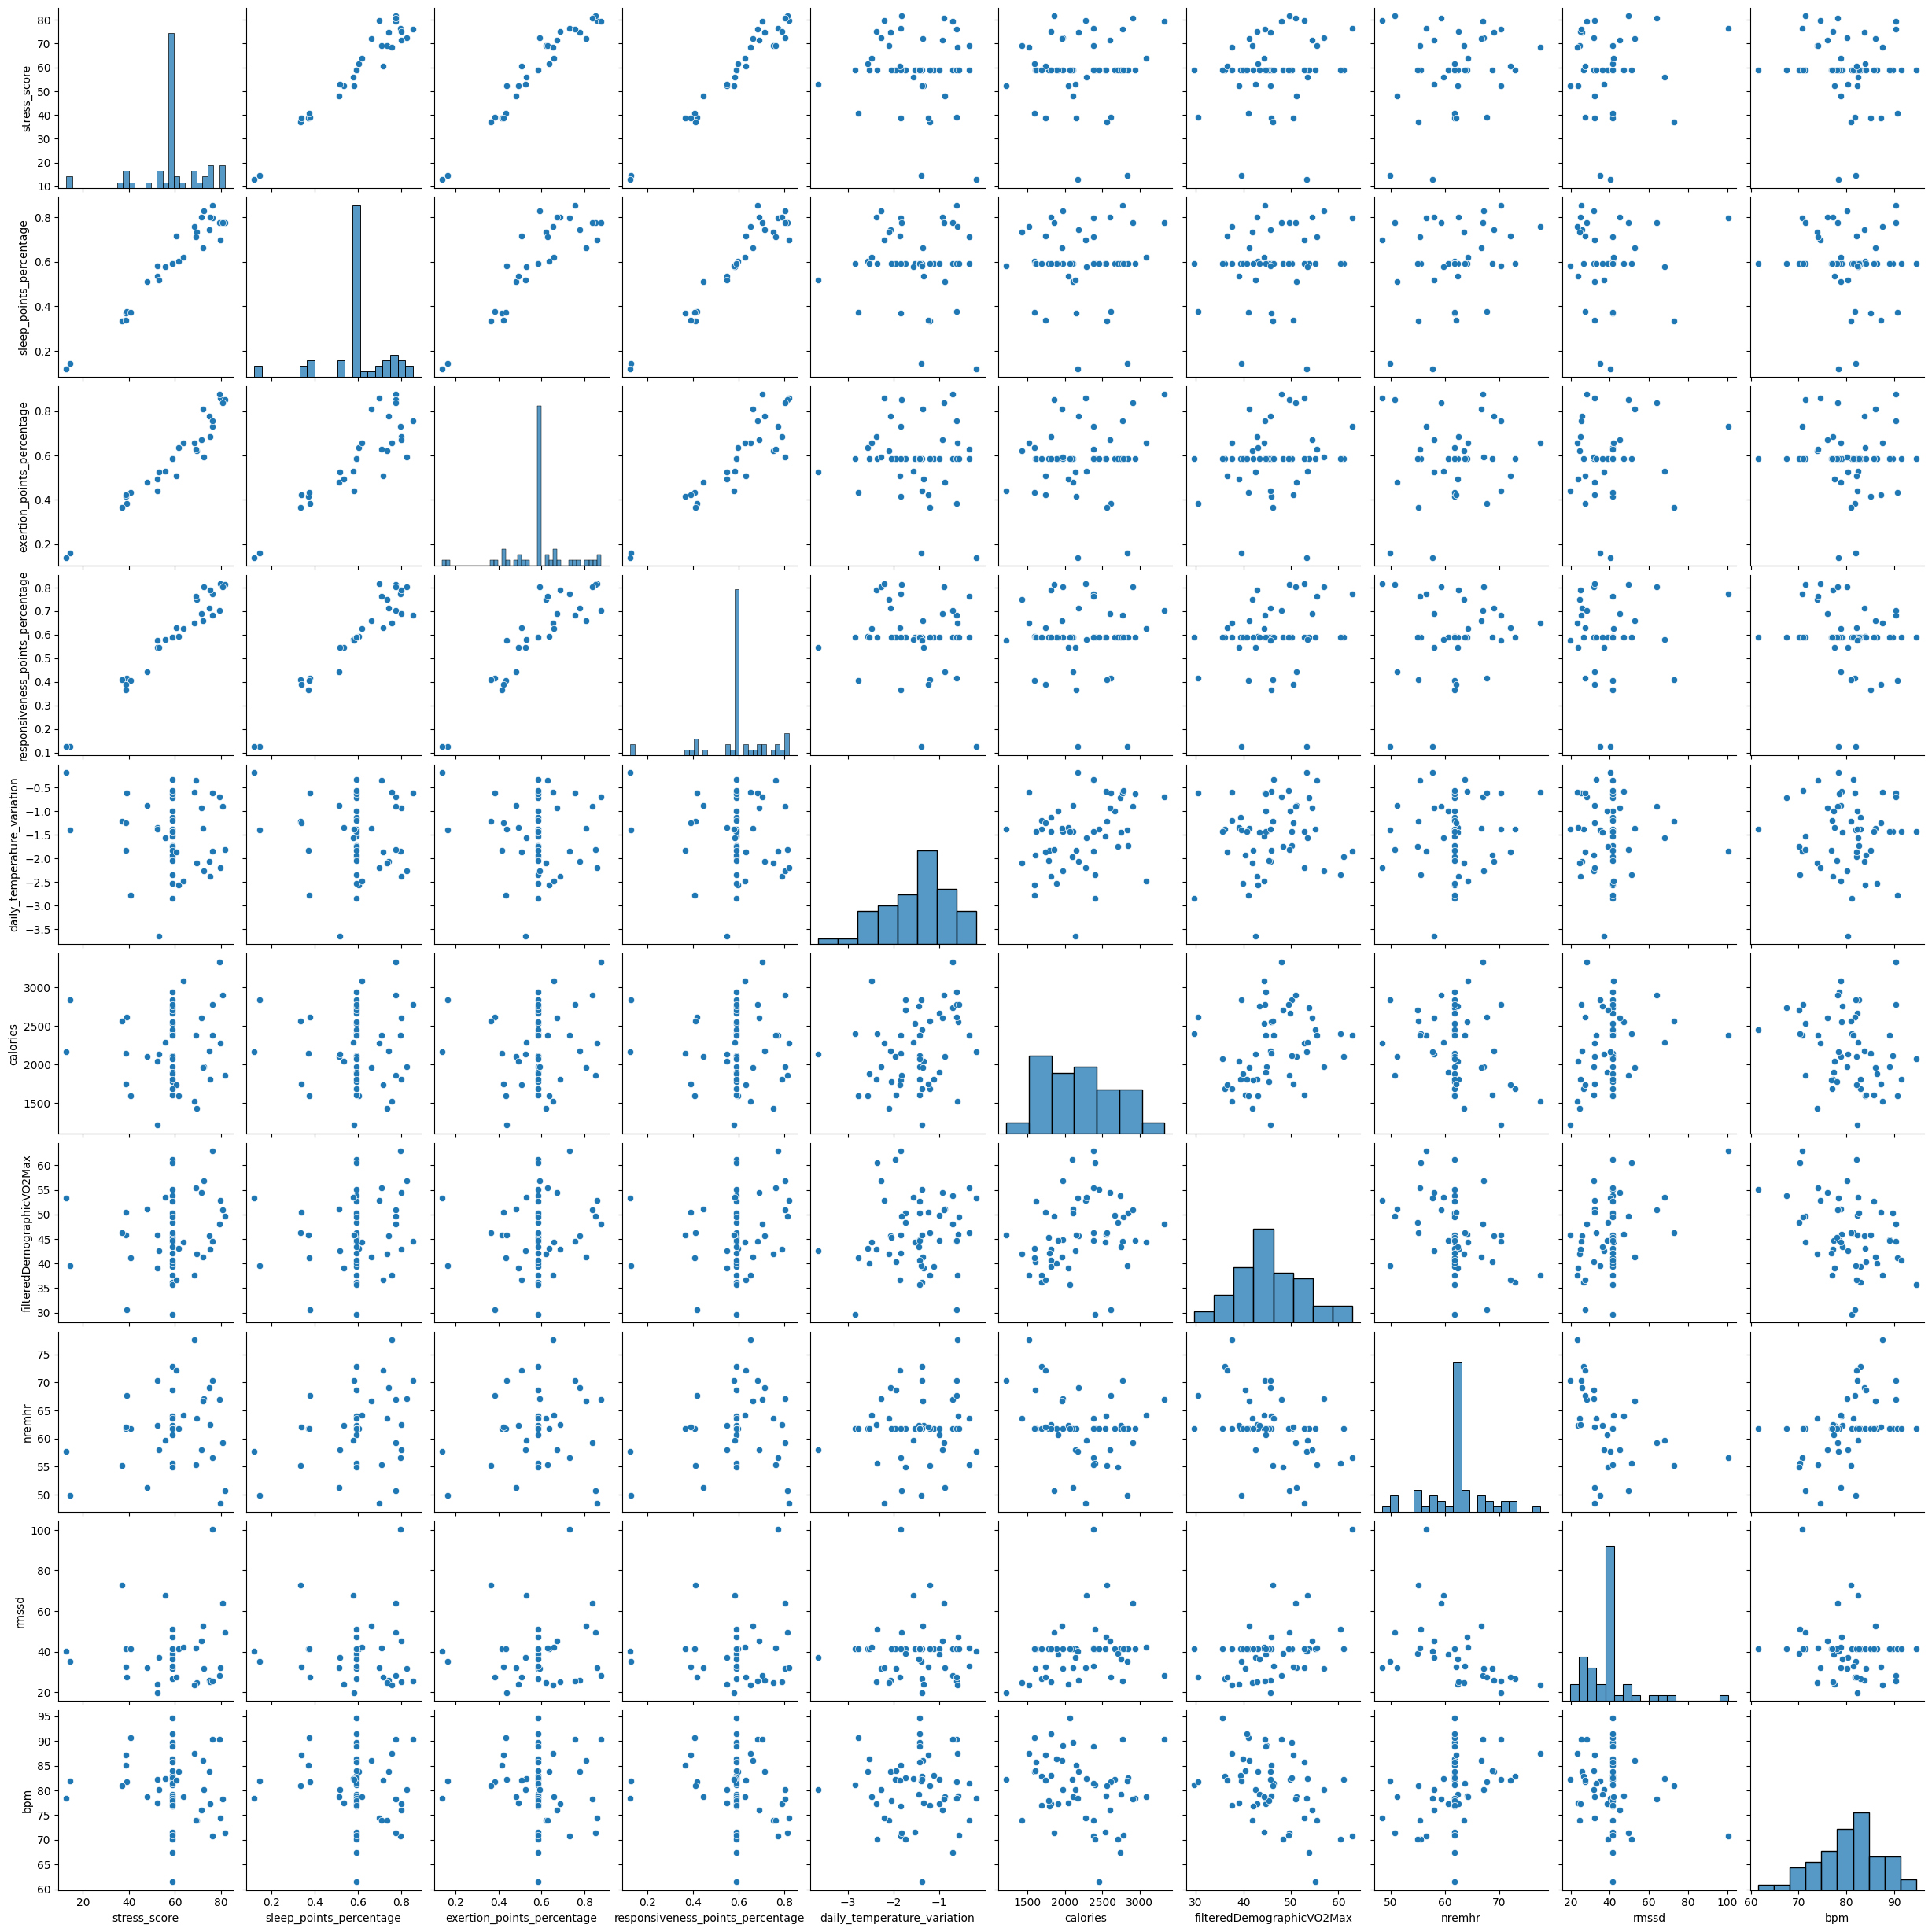

In [ ]:
#Evidenciar diagramas de dispersion para algunos atributos 
dataframe_train = training_examples.copy()
dataframe_train["target"] = training_targets["stress_score"]

cols = ["stress_score", 
     "sleep_points_percentage",
     "exertion_points_percentage", 
     "responsiveness_points_percentage",
     "daily_temperature_variation", 
     "calories", 
     "filteredDemographicVO2Max",
     "nremhr","rmssd", 
     "bpm"]

plt.figure(figsize = (100,100))

sns.pairplot(dataframe_train[cols])

##4. Regresión Lineal

In [ ]:
#creacion del modelo
regression = linear_model.LinearRegression()
#train of data x and train of label y
train_x = np.asanyarray(training_examples[['sleep_points_percentage']])
train_y = np.asanyarray(training_targets[['stress_score']])

#entrenamiento del modelo
regression.fit(train_x, train_y)
# Coeficientes
print ('Coefficients: ', regression.coef_)
print ('Intercept: ',regression.intercept_)

Coefficients:  [[90.04484971]]
Intercept:  [5.31877789]


Text(0, 0.5, 'stress_score')

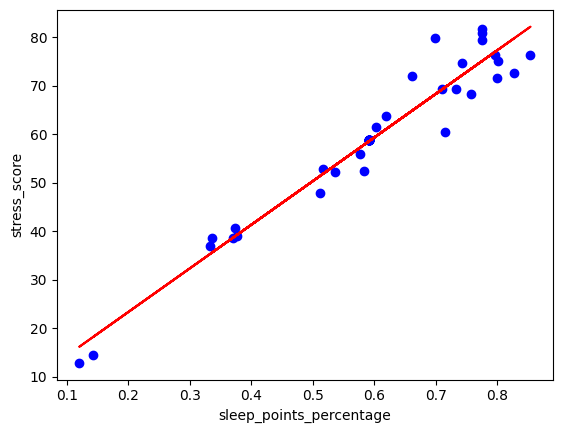

In [ ]:
plt.scatter(training_examples.sleep_points_percentage, training_targets.stress_score,  color='blue')
plt.plot(train_x, regression.coef_[0][0]*train_x + regression.intercept_[0], '-r') #regression lineal
plt.xlabel("sleep_points_percentage")
plt.ylabel("stress_score")


En primera instancia se hizo el entrenamiento con los parámetros de rmssd y bpm pero no existe una buena correlación entre estos dos datos, por lo tanto se hace ahora con el porcentaje de sueño y el puntaje de estrés.

### Métricas de evaluación de modelos

MSE : permite calcular la exactitud del modelo basado en el set de prueba:

Error absoluto de media: Es una media del valor absoluto de los errores. Es la métrica más fácil de comprender ya que es el promedio de los errores.
Error Cuadrado Medio (MSE): El Error Cuadrado Medio (MSE) es la media del error cuadrático. Es más popular que el error de Media absoluto ya que hace foco en grandes errores. Esto se debe a que el término cuadrático tiene errores más grandes que van aumentando su valor.
Error Cuadrático Medio (RMSE).
R-cuadrática: Esta metrica es una medida popular para darle precisión al modelo. Representa cuán cerca están los datos de la linea de regresión ajustada. Mientras más alto el R-cuadrático, mejor se encontrará ajustado el modelo respecto de los datos. El puntaje mejor posible es 1.0 y puede tomar valores negativos .

**Nota: se agragaron otras métricas para evaluar el modelo de las que se tenian en la propuesta inicial**

In [ ]:
test_x = np.asanyarray(validation_examples[['sleep_points_percentage']])
test_y = np.asanyarray(validation_targets[['stress_score']])
test_y_predict = regression.predict(test_x)


print("Error medio absoluto: %.2f" % np.mean(np.absolute(test_y_predict - test_y)))
print("Suma residual de los cuadrados (MSE): %.2f" % np.mean((test_y_predict - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_predict , test_y) )

Error medio absoluto: 1.88
Suma residual de los cuadrados (MSE): 8.54
R2-score: 0.93


### Cruva de aprendizaje

In [ ]:
def rel_mrae(regression, train_x, train_y):
    preds = regression.predict(train_x)
    return np.mean(np.abs(preds-train_y)/train_y)

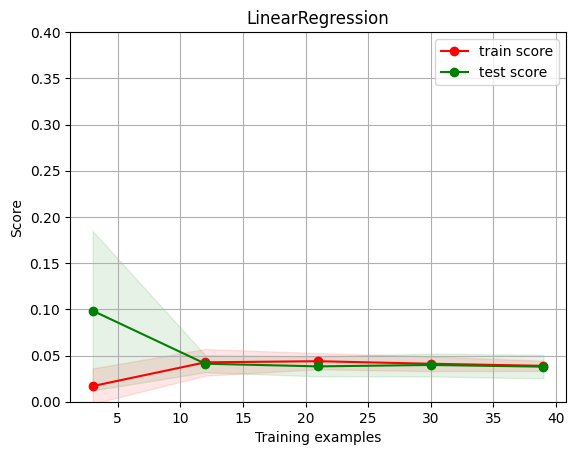

In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=.3)
ch.plot_learning_curve(regression, regression.__class__.__name__, train_x, train_y, 
                       cv=cv, scoring=rel_mrae, ylim=(0,0.4))

## 5. Arboles de decisión

In [ ]:
z = np.asanyarray(newData[['sleep_points_percentage']])
w = np.asanyarray(newData[['stress_score']])

In [ ]:
# Se separán los datos en train, test y validación
train_size = 0.8

# Se separan los datos de entrenamiento
z_train, z_rem, w_train, w_rem = train_test_split(z, w, train_size=0.8)

# Se separán los datos de validación y de test
test_size = 0.5
z_valid, z_test, w_valid, w_test = train_test_split(z_rem, w_rem, test_size=0.5)

print(z_train.shape)
print(w_train.shape)
print(z_valid.shape)
print(w_valid.shape)
print(z_test.shape) 
print(w_test.shape)

(56, 1)
(56, 1)
(7, 1)
(7, 1)
(8, 1)
(8, 1)


In [ ]:
from sklearn.tree import DecisionTreeRegressor
decisionTree = DecisionTreeRegressor(max_depth=8)
decisionTree.fit(z_train,w_train)


DecisionTreeRegressor(max_depth=8)

In [ ]:
#Probamos el score entre X_test y Y_test
decisionTree.score(z_test, w_test)

0.9686475612538933

In [ ]:
decisionTree.score(z_valid, w_valid)

0.7685712938880889

###Curva de aprendizaje

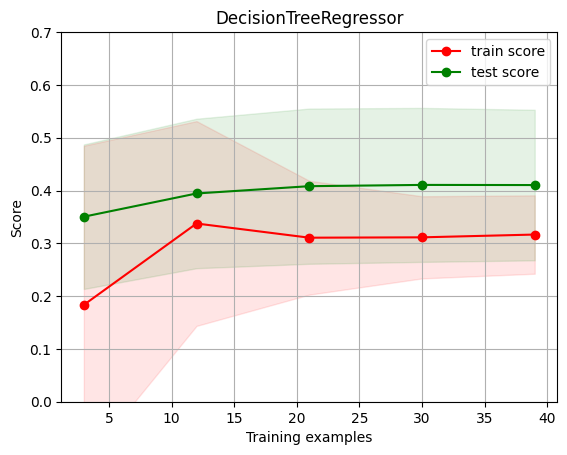

In [ ]:
ch.plot_learning_curve(decisionTree, decisionTree.__class__.__name__, z_train, w_train, cv=cv, scoring=rel_mrae, ylim=(0,0.7))